# Take Home Assignment - Churn Prediction


### Predicting Churn rate
Problem statement: 
Sometimes a merchant may stop processing, which we call churn. We are interested in identifying and predicting churn. Please a) come up with a concrete definition for churn b) identify merchants that have already churned in the dataset, and c) build a model to predict which active merchants are most likely to churn in the near future.


#### 1) Introduction
I would approach this problem from 4 areas: 1) Problem definition set up, 2) Data analysis and feature generation, 3) Model and benchmark evaluation, 4) potential application.


#### 2) Problem Definition Set Up

The goal of the exercise is to identify and predict customer churn so that we can engage with the customers early and reactivate their transactions by applying marketing strategy or figuring out what the underlining problem is. The science goal is to achieve certain precisin recall with the churn prediction model and it should be x% better than the benchmark solution.

First, we need to define the target based on how long a customer has been inactive. Defining a churn period that is too long risks not capturing enough people and missing the opportunity to save the customers. However, defining a churn period too short makes it difficult for marketing teams to evaluate churn prevention campaigns because they ultimately can’t distinguish between organic actions (users or customers who would have come back anyway) and effective campaign. In order to determine the target churn period, I have looked at all the merchant’s transactions and calculate what the intervals are between their successive transaction date. This will tell us what the organic interval distribution is for customers who would have come back anyway without intervention. It is found that 96.4% of the customers would have made a successive transaction with a maximum of 30-days window, 98.4% with a 60-days window and 99% with a 90-day window. Typically, we need to align with the business team on the churn period for the definition of the target based on the distribution. Here, I will use 30-day inactive window to be the target because there is only 3.6% (1-96.4%) of the organic customer transactions that are occurred after 30 days of inactivity.

Second, I need to define where and how this prediction model should be used and what the user experience is like in using the model. I assume we have limited marketing and operations resources that we would not be able to reach out to every customer that has a potential to churn. Therefore, our goal is to identify the merchants with the highest probability to churn as early as possible to reengage and reactivate their transactions through marketing strategies. I will predict the probability of customer churn (30-day consecutive inactivity) on a daily basis for merchants that don't have any transactions**. Since we won't be able to reach out to every customer, I expect the marketing team would use my model with the highest scores to send engagement marketing strategy. We can then maximize our ROI for the marketing effort. We would exclude customers who don't have any transactions in the past 30 days since they are already churned (too late to save). Our model target is whether the customer will have a consecutive 30-day inactivity in that cycle. For example, if we make a prediction on a merchant who hasn't had any transactions for the past 5 days, then our target is whether he will remain inactive for the next 25 days consecutively. 

Third, we need to determine how to evaluate our model with a proper benchmark. One way to define the benchmark is based on simple heuristic rule. A potential solution is to engage with the merchants based on days of consecutive inactivity. We know that the higher the number of consecutive inactivity days, the more likely someone will churn. For example, a simple marketing strategy is to engage with all the customers who have been inactive for at least 5 days. We can measure what the precision recall are for this cohort of merchants against our churned target. We can compare this simple strategy performance (PR) with the same number of people we would have chosen based on the highest model scores. We also expect the model will cover customers who has been inactive for fewer than 5 days, which means we can reach out to customers earlier to prevent churn. For online real world model execution, we also need to launch A/B testing to compare model driven strategy vs. the strategy based on consecutive inactivity to see which one will drive better retention rate.


** Based on paper research, I found other churn prediction model structure that would score everyone regardless if they are inactive or active [5]. However, I don't like this solution as its target definition would not be consistent between active and inactive customers. It is also more confusing to explain the target to business teams.


#### 3) Train/Test Data and feature generation

We will create the following features for our supervised learning model:

'rolling_sum_30': sum of dollar transaction values in the past 30 days
'rolling_sum_15': sum of dollar transaction values in the past 15 days
'rolling_freq_30': total number of transactions in the past 30 days
'rolling_freq_7': total number of transactions in the past 7 days
'date_to_first_transaction': how many days since the first transaction in the data file
'rolling_freq_15': total number of transactions in the past 15 days
'rolling_freq_60': total number of transactions in the past 60 days
'rolling_freq_90': total number of transactions in the past 90 days
'recency': how long has the merchant been inactive
'dollar_transaction_velocity_15': ratio of past 15 days dollar transaction divided by past 30 days dollar transaction
'freq_transaction_velocity_15': ratio of past 15 days number transaction divided by past 30 days number transaction
'freq_transaction_velocity_7': ratio of past 7 days number transaction divided by past 15 days number transaction
'freq_transaction_velocity_30': ratio of past 30 days number transaction divided by past 60 days number transaction
'freq_transaction_velocity_60': ratio of past 60 days number transaction divided by past 90 days number transaction


The hypothesis is that we can see attrition trends with these past transactions and velocity 

I select 10 random days in 2033 and 2034 as my training and out of sample test set. The data include all customer who have at least one transaction in the past 29 days (recency <30). The target is whether the customer will be churned in that cycle (consecutive 30 days no activity). 

Due to time constraint, insightful data/feature analysis was ommited.


#### 4) Model and Benchmark evaluation

I use lightgbm classification model for this exercise. I train the data on 2033 data and applied it to 2034 data for test evaluation. The model achieves AUC of 0.89 with a precision of 72% and recall of 64% with score cut-off at 0.5 on out of time out of sample test data.

There are a few things I could have done but didn't do due to time constraint:
1. experiment with different algorithm (e.g. xgboost etc.)
2. paremeter tuning with cross validation and grid search
3. variable exploration
4. feature importance analysis
5. model score calibration - turning it into probability

As mentioned in the Problem definition section, in order to evaluate the model performance, we need to find a good benchmark. For this problem, I propose a business strategy of engaging with customers who have been inactive for at least 5 straight days. I want to compare this group's performance with the same number of people based on top model score. There are two things we can compare: first is the precision recall between the two group, the other is the distribution of the number of consecutive inactive days.

The model performance was evaluated on year 2034 data with 10 random days that are at least 30 days apart. The performance of the heuristic rule for predicting churn rate on merchants with at least 5 consecutive inactive days has a precision 54% with 85% recall. There are 21.4k of merchants that fall under this condition. With the same amount of people based on highest churn rate model score, we are able to achieve 57% precision with 90% recall. This means by using our model, the business team will be able to identify more churned customers when they reach out to the same number of people (we will be able to identify 5% more customers who will churn).
Also, I have plotted the distribution of the captured customers based on model score. 11% of the true positives have been inactive for less than 5 days. This means by using our model score, we can also identify potential churned customers earlier than the benchmark of reaching out to the customers that have been inactive for at least 5 days.

It is noted that for real world evaluation, we need to launch A/B testing to compare different strategy based on customer retention rate.


#### 5) Potential Application

As mentioned before, the business team can use the model score that we score on a daily basis to determine who they can engage with based on the highest model score. They can also engage with the customer to gather feedbacks on key reasons for churn and use those feedbacks to better improve the product. 



#### Appendix 1 - Research Papers and Some Tutorials

[1] Ching hue Cheng, You Shiyang Chen, "Classifying the segments of customer value via RFM model and RS theory”, Expert Systems with Ap- plications 36 (2009) 4176–4184, Department of Information Manage- ment, National Yunlin University of Science and Technology, 123, Section 3, University Road, Touliu, Yunlin 640, Taiwan,2009 . 

[2] Amir Hossein Azadnia, Pezhman Ghadimi, Mohammad Molani- Agama, ‘”A Hybrid Model of Data Mining and MCDM Methods for Estimating Customer Lifetime Value” , Proceedings of the 41st International Conference on Computers & Industrial Engineering, Department of Engineering, Ayatollah Amole branch, Islamic Azad University, Amol, Iran, Department of Manufacturing & Industrial Engineering, University Teknologi Malay- sea, Skudai, Malaysia. 

[3] Tristan Ganry, "How to automatically segment customers" https://towardsdatascience.com/how-to-automatically-segment-customers-using-purchase-data-and-a-few-lines-of-python-36939fb587a4


[4] https://www.sciencedirect.com/science/article/pii/S2666827020300013

[5] https://cdn2.hubspot.net/hubfs/2123903/PDF/Whitepaper/guidebook-churn-prediction.pdf


#### Appendix 2 - Data Exploration Insight


Based on data exploration, I have the following findings:
1) there are some outliers in the dataset in terms of number of transactions and maximum transaction amount. (e.g., merchant 654930c922 has over 9000 transactions on 2033-01-13, merchant 5608f200cf has over 25k transactions)

2) total number and dollar transactions have increased from 2033 to 2034





In [ ]:
#import relevant library
import pandas as pd 
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import logging
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix

%matplotlib inline

# Churn Rate Prediction

In [24]:
#load data
df = pd.read_csv('takehome_ds_written.csv')


In [39]:
#create date and hour feature for the data
df['time_date'] = pd.to_datetime(df['time']).dt.date
df['time_hour'] = pd.to_datetime(df['time']).dt.hour
df['time_date_str'] = df['time'].str[:10]

In [40]:
# create distribution of transaction intervals for merchants
df_interval=df.groupby(['merchant', 'time_date'])['merchant'].count()
df_interval=df[['merchant', 'time_date']].drop_duplicates()
df_interval=df_interval.sort_values(by= ['merchant', 'time_date'], ascending=True)
df_interval['dif'] = df_interval.groupby('merchant')['time_date'].diff(-1) * (-1)
df_interval['dif']=df_interval['dif'].dt.days

<AxesSubplot:xlabel='dif'>

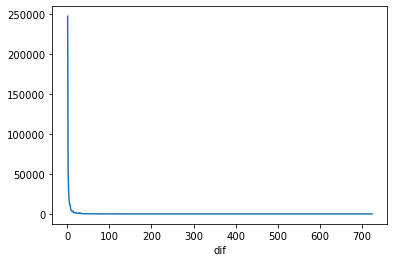

In [41]:
# plot the interval with the plot, it is difficult to observe from the plot due to long tail
df_interval.groupby('dif')['dif'].count().plot()

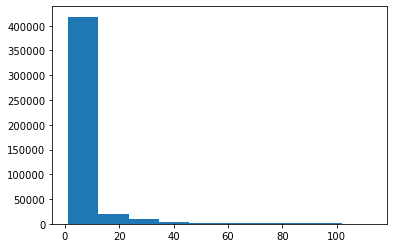

In [38]:
#df_interval.groupby('dif')['dif'].count().quantile(0.95)

_=plt.hist(df_interval[df_interval['dif']<=df_interval['dif'].quantile(0.993)]['dif'])

In [42]:
# Want to manually check what the percentage of customer would come back organicly by putting condition 
# on interval days.

# print percentage of customers that will come back within 30 days of inactive
print(len(df_interval[df_interval['dif']<=30])/len(df_interval[df_interval['dif']<=800]))

# print percentage of customers that will come back within 60 days of inactive
print(len(df_interval[df_interval['dif']<=60])/len(df_interval[df_interval['dif']<=800]))

# print percentage of customers that will come back within 90 days of inactive
print(len(df_interval[df_interval['dif']<=90])/len(df_interval[df_interval['dif']<=800]))

0.9643099895112413
0.983875976399207
0.9903798754812777


In [43]:

# Here I want to create cross join dataset with all customer and dates combination (include days without transactions)
# create cross join to get all merchant date combination
df_dates=df['time_date_str'].drop_duplicates()
df_dates=pd.Series(df_dates,name="time_date_str").to_frame()
df_merchant=df['merchant'].drop_duplicates()
df_merchant=df_merchant.to_frame()
df_dates['key']=0
df_merchant['key']=0
df_cross=pd.merge(df_merchant, df_dates , on ='key', how ='outer')
df['flag']=1
df_combine=df_cross.merge(df, on=['merchant','time_date_str'], how='left')
df_combine['flag'].fillna(0, inplace=True)
df_combine=df_combine.sort_values(['merchant','time_date_str'], ascending=False)
df_combine=df_combine.reset_index()



In [44]:
# Here i am creating a group by on merchant and date primary so that each customer and date has only one row
# I am summing the transaction amount and number of transactions per day
df_combine_new1=df_combine.groupby(['merchant', 'time_date_str', 'flag'])['amount_usd_in_cents'].sum().reset_index(name='tot_amount')
df_combine_new2=df_combine.groupby(['merchant', 'time_date_str', 'flag'])['amount_usd_in_cents'].count().reset_index(name='tot_freq')
df_final=df_combine_new1.merge(df_combine_new2[['merchant', 'time_date_str','tot_freq']], on = ['merchant', 'time_date_str'], how ='inner')

In [45]:

# Here i am creating new feature for the dataset for rolling past x days data to get some key features for the model

df_final['date']=pd.to_datetime(df_final['time_date_str'])
df_final=df_final.sort_values(['merchant', 'time_date_str'])

# we want to see how much total dollar transaction a customer is making in the past x days
df_final['rolling_sum_30'] = df_final.groupby('merchant').tot_amount.apply(lambda x: x.rolling(30).sum())
df_final['rolling_sum_15'] = df_final.groupby('merchant').tot_amount.apply(lambda x: x.rolling(15).sum())
df_final['rolling_sum_60'] = df_final.groupby('merchant').tot_amount.apply(lambda x: x.rolling(60).sum())
df_final['rolling_sum_90'] = df_final.groupby('merchant').tot_amount.apply(lambda x: x.rolling(90).sum())
df_final['rolling_sum_7'] = df_final.groupby('merchant').tot_amount.apply(lambda x: x.rolling(7).sum())
df_final['rolling_freq_30'] = df_final.groupby('merchant').tot_freq.apply(lambda x: x.rolling(30).sum())
df_final['rolling_freq_15'] = df_final.groupby('merchant').tot_freq.apply(lambda x: x.rolling(15).sum())
df_final['rolling_freq_60'] = df_final.groupby('merchant').tot_freq.apply(lambda x: x.rolling(60).sum())
df_final['rolling_freq_90'] = df_final.groupby('merchant').tot_freq.apply(lambda x: x.rolling(90).sum())
df_final['rolling_freq_7'] = df_final.groupby('merchant').tot_freq.apply(lambda x: x.rolling(7).sum())



In [46]:


# Here I remove all merchant and date combination before their first transaction in the dataset
df_min_date=df_final[df_final['flag']==1].groupby('merchant')['date'].min().reset_index()
df_trim=df_final.merge(df_min_date, on='merchant', how='left')
df_trim=df_trim[df_trim['date_x']>=df_trim['date_y']].reset_index()

# create recency column to count how many days the customer is being inactive
df_trim['recency'] = df_trim.groupby((df_trim['flag'] != df_trim['flag'].shift(1)).cumsum()).cumcount()+1
df_trim['recency'].mask(df_trim['flag'] == 1, 0, inplace=True)

# feature on date to first transaction
df_trim['date_to_first_transaction'] = (df_trim['date_x']-df_trim['date_y']).dt.days

In [47]:
# create features to calculate the velocity of past 15 days transactions divided by past 30 days.

df_trim ['dollar_transaction_velocity_15'] = df_trim['rolling_sum_15']/df_trim['rolling_sum_30']
df_trim ['freq_transaction_velocity_15'] = df_trim['rolling_freq_15']/df_trim['rolling_freq_30']

df_trim ['freq_transaction_velocity_7'] = df_trim['rolling_freq_7']/df_trim['rolling_freq_15']
df_trim ['freq_transaction_velocity_30'] = df_trim['rolling_freq_30']/df_trim['rolling_freq_60']
df_trim ['freq_transaction_velocity_60'] = df_trim['rolling_freq_60']/df_trim['rolling_freq_90']


# This step is important in determining the target!!

# create the rolling sum to see whether the merchant to check whether there is 30 days consecutive inactivity 
# this is the key in determining the target since we define churn as 30 days consecutive inactivity
df_trim=df_trim.sort_values(['merchant', 'time_date_str'], ascending=False)
df_trim['rolling_sum'] = df_trim.groupby('merchant').flag.apply(lambda x: x.rolling(30).sum())
#df_trim['rolling_flag_yn'] = df_trim['rolling_sum'].apply(lambda x: 1 if x == 0 else 0)

In [48]:


# create the flag that will tell us if a seller would have been inactive for more than 30 days and label the start
# of the sequence with a 1

df_trim['final_flag']=0
df_trim.loc[(df_trim['recency'] == 1) & (df_trim['rolling_sum']==0 ), 'final_flag'] = 1
df_trim.sort_values(['merchant', 'time_date_str'], inplace=True)


# Important Step! 
# create a function to label the rest of the 29 days as our true positive labels.
# This will help us identify the merchants that are in the churn period
df_trim['flag_30'] = np.nan
df_trim.loc[df_trim.final_flag == 1, 'flag_30'] = 1
df_trim['flag_30'] = df_trim.flag_30.ffill(limit=29).fillna(0).astype(int)


In [49]:
# create a model data where we only consider if there is a transaction in the past 30 days. 
# also, we want to only make prediction before a seller becomes a "churn" (consecutive 30 days no activity)
df_model = df_trim[df_trim['recency']<30][['merchant', 'time_date_str', 'flag', 'tot_amount', 'tot_freq',
       'date_x', 'rolling_sum_30', 'rolling_sum_15', 'rolling_freq_30','rolling_freq_7', 'date_to_first_transaction'
       ,'rolling_freq_15', 'rolling_freq_60','rolling_freq_90', 'recency', 'dollar_transaction_velocity_15',
       'freq_transaction_velocity_15', 'freq_transaction_velocity_7','freq_transaction_velocity_30', 'freq_transaction_velocity_60',
        'flag_30']]

In [50]:
# Create train and test data set

df_train = df_model[df_model['time_date_str']<'2034-01-01']
df_test = df_model[df_model['time_date_str']>='2034-01-01']

# create random dates to train and evaluate model
date_t=['2033-01-01', '2033-02-02','2033-03-05', '2033-04-07', '2033-05-10', 
        '2033-06-14', '2033-07-16', '2033-08-20', '2033-09-30', '2033-11-20'  ]

date_test=['2034-01-01', '2034-02-02','2034-03-05', '2034-04-07', '2034-05-10', 
        '2034-06-14', '2034-07-16', '2034-08-20', '2034-09-30', '2034-11-20'  ]

In [51]:

# create the train and test data set with the random date
df_train=df_train[df_train['time_date_str'].isin(date_t) ]
df_test=df_test[df_test['time_date_str'].isin(date_test) ]

# create an in-sample train and test
train, test, y_train, y_test = train_test_split(df_train, df_train.flag_30, test_size=0.1, random_state=42)

# define features and target.
target='flag_30'
keep_col=['rolling_sum_30', 'rolling_sum_15', 'rolling_freq_30','rolling_freq_7', 'date_to_first_transaction'
       ,'rolling_freq_15', 'rolling_freq_60','rolling_freq_90', 'recency', 'dollar_transaction_velocity_15',
       'freq_transaction_velocity_15', 'freq_transaction_velocity_7',
        'freq_transaction_velocity_30', 'freq_transaction_velocity_60']



In [52]:

# create LGBM model 
import lightgbm as lgbm
model = lgbm.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, n_estimators=200, max_depth=5,
                                bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

# fit the model with train data
model=model.fit(train[keep_col], train[target])

[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


In [53]:
# score the data back to train data set

train['pred_prob']=model.predict_proba(train[keep_col])[:,1]
train['pred']=model.predict(train[keep_col])

#Print model report on training data (confirm it is overfitting result)
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(train[target].values, train['pred']))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(train[target], train['pred_prob']))


Model Report
Accuracy : 0.8463
AUC Score (Train): 0.932006


<ipython-input-53-67e963490594>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred_prob']=model.predict_proba(train[keep_col])[:,1]
<ipython-input-53-67e963490594>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['pred']=model.predict(train[keep_col])


In [54]:

# score the test data set
test['pred_prob']=model.predict_proba(test[keep_col])[:,1]
test['pred']=model.predict(test[keep_col])

#Print model report (confirm it is overfitting result)
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(test[target].values, test['pred']))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(test[target], test['pred_prob']))


Model Report
Accuracy : 0.8012
AUC Score (Train): 0.882585


<ipython-input-54-aeac1459075c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_prob']=model.predict_proba(test[keep_col])[:,1]
<ipython-input-54-aeac1459075c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred']=model.predict(test[keep_col])


In [56]:
df_test['pred_prob']=model.predict_proba(df_test[keep_col])[:,1]
df_test['pred']=model.predict(df_test[keep_col])

#Print model report on in sample test data
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(df_test[target].values, df_test['pred']))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(df_test[target], df_test['pred_prob']))



Model Report
Accuracy : 0.8082
AUC Score (Train): 0.885066


In [929]:

# print confusion matrix on out of sample test data.
confusion_matrix(df_test[target].values, df_test['pred'])

array([[26301,  3358],
       [ 4929,  8615]])

In [930]:
# check model perf on out of sample test data using 0.5 cutoff
cutoff=0.5
print ("Precision Rate is:")
print (sum(df_test[df_test['pred_prob']>=cutoff][target])*1.0/len(df_test[df_test['pred_prob']>=cutoff]))
print ("Number of predicted cases:")
print  (len(df_test[df_test['pred_prob']>=cutoff]))
print ("Recall Rate is:")
print (sum(df_test[df_test['pred_prob']>=cutoff][target])*1.0/sum(df_test[target]))
print ("Score Cutoff is:")
print (float(cutoff))

Precision Rate is:
0.7195356218157521
Number of predicted cases:
11973
Recall Rate is:
0.6360750147666864
Score Cutoff is:
0.5


In [934]:
#benchmark comparison 
# heuristic rule performance with 21475 customers with recency greater equal to 5 consecutive days


print ("Precision Rate is:")
print(sum(df_test[df_test['recency']>=5][target])*1.0/len(df_test[df_test['recency']>=5]))
print ("Recall Rate is:")
print (sum(df_test[df_test['recency']>=5][target])*1.0/sum(df_test[target]))
print ('how many cases with recency>=5:')
print (len(df_test[df_test['recency']>=5]))

Precision Rate is:
0.5416530849825378
Recall Rate is:
0.8588304784406379
how many cases with recency>=5:
21475


In [58]:
# important bechmark comparison where model result with the similar 21458 number of customers from top model score
# ML model result beat benchmark with 3% higher precision and 5% higher recall!

cutoff=0.167
print ("Precision Rate is:")
print (sum(df_test[df_test['pred_prob']>=cutoff][target])*1.0/len(df_test[df_test['pred_prob']>=cutoff]))
print ("Number of predicted cases:")
print  (len(df_test[df_test['pred_prob']>=cutoff]))
print ("Recall Rate is:")
print (sum(df_test[df_test['pred_prob']>=cutoff][target])*1.0/sum(df_test[target]))
print ("Score Cutoff is:")
print (float(cutoff))

Precision Rate is:
0.5714884891415789
Number of predicted cases:
21458
Recall Rate is:
0.9054193738924985
Score Cutoff is:
0.167


<AxesSubplot:>

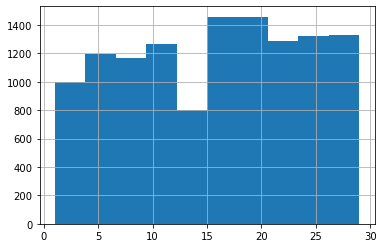

In [59]:

# we can see that the recency distribution of the TP by the model include many merchants whose recency is <10 days.
# this means we are able to engage them faster than the benchmark of reaching out in 10 days
df_test[(df_test['pred_prob']>=cutoff) & (df_test[target]==1)]['recency'].hist()

In [953]:
# check % of TP customers from model prediction that are also less than 5 days. This measn we can 
# capture churned customers ealier than heuristic rules

len(df_test[(df_test['pred_prob']>=cutoff) & (df_test[target]==1) & (df_test['recency']<5) ])/ len(df_test[(df_test['pred_prob']>=cutoff) & (df_test[target]==1)  ])

0.11098426159993477

In [61]:
df_test[(df_test['pred_prob']>=cutoff) & (df_test[target]==1)]['recency'].to_csv("recency.csv")